# Hierarchical Clustering and Cluster Evaluation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples

## Goal 

Use hierarchical clustering to group states based on votes cast in past elections. The groups generated could be used to inform political campaigns and identify swing states. 

## Data

The data used is from the American Presidency Project and is split into two files:
- votes_by_state.csv has the raw number of ballots cast for each of the top presidential candidates from 2008-2012 by US State (and the District of Columbia)
- republican_percentage_by_state.csv has the percentage of votes that were for the Republican candidate for 2008, 2012, and 2016 by US State (and the District of Columbia)

In [6]:
df_X = pd.read_csv('https://gist.githubusercontent.com/TieJean/a63b4d51246aec6b73bb75944dd69ead/raw/292d338340efa19b8b47958ee4cfcca5e3d8e09c/votes_by_state.csv')
s_states = df_X['State']
df_X = df_X.drop(columns=['State'])

In [7]:
df_X = pd.read_csv('https://gist.githubusercontent.com/TieJean/74d13de3875643140d620f0664e1c933/raw/294658528271118725d4b10779cbb430597cf07d/republican_percentage_by_state.csv')
s_states = df_X['State']
df_X = df_X.drop(columns=['State'])

## Testing different proximity measures 

Plot the hierarchical clusters formed from the raw vote count using 3 proximity measures: ward, min, and max. 

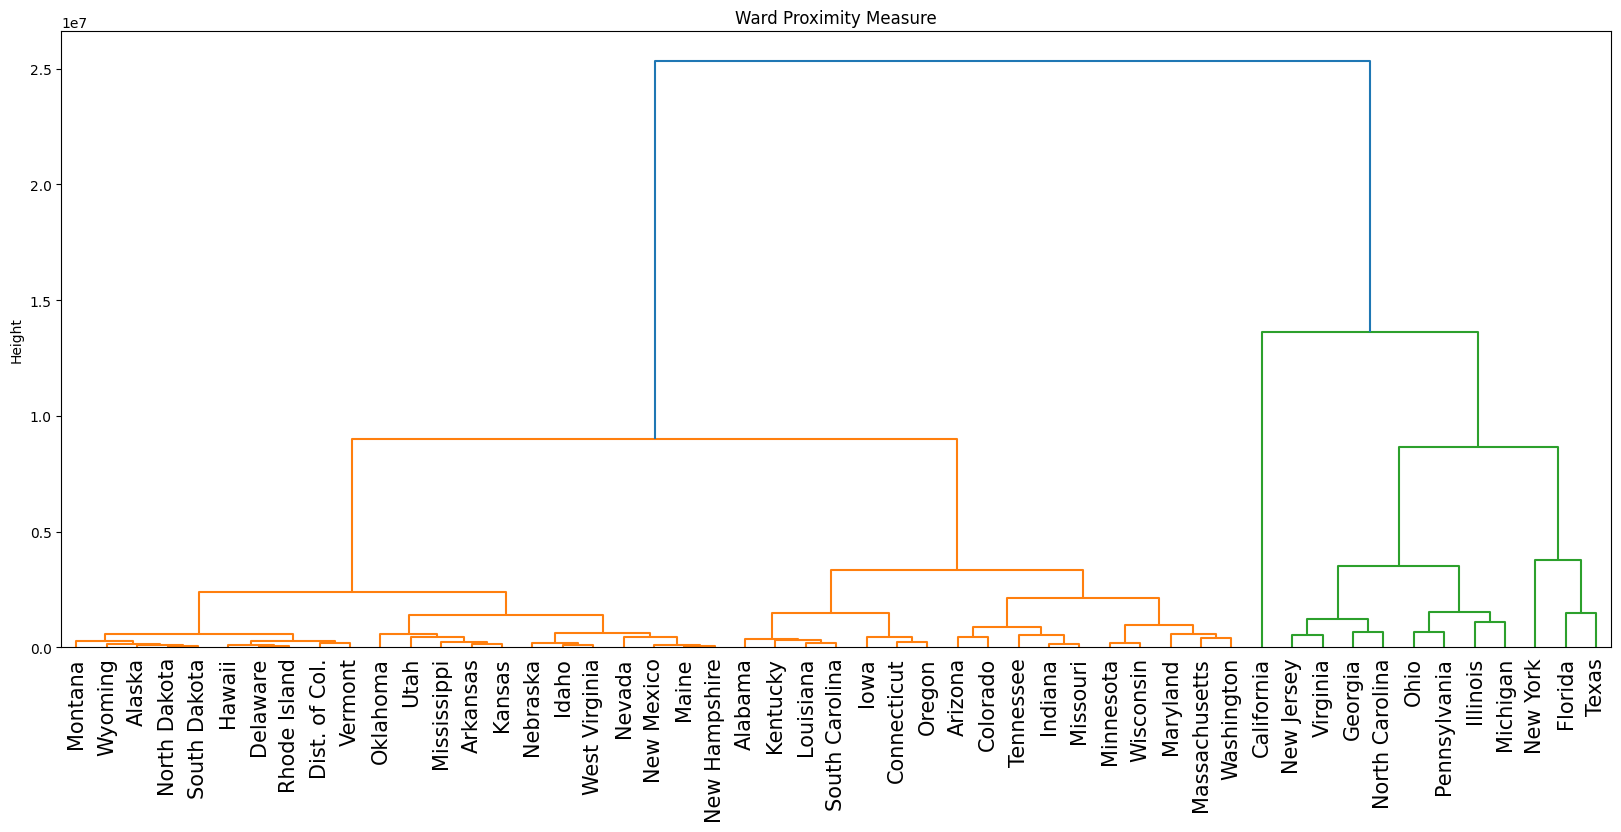

In [3]:
# Plot the dendrogram for the Ward proximity measure
distances = pdist(df_X)
Z = linkage(distances, method='ward')
plt.figure(figsize=(20, 8))
dn = dendrogram(Z, labels = s_states.tolist(), leaf_font_size = 15)
plt.ylabel('Height')
plt.title('Ward Proximity Measure');

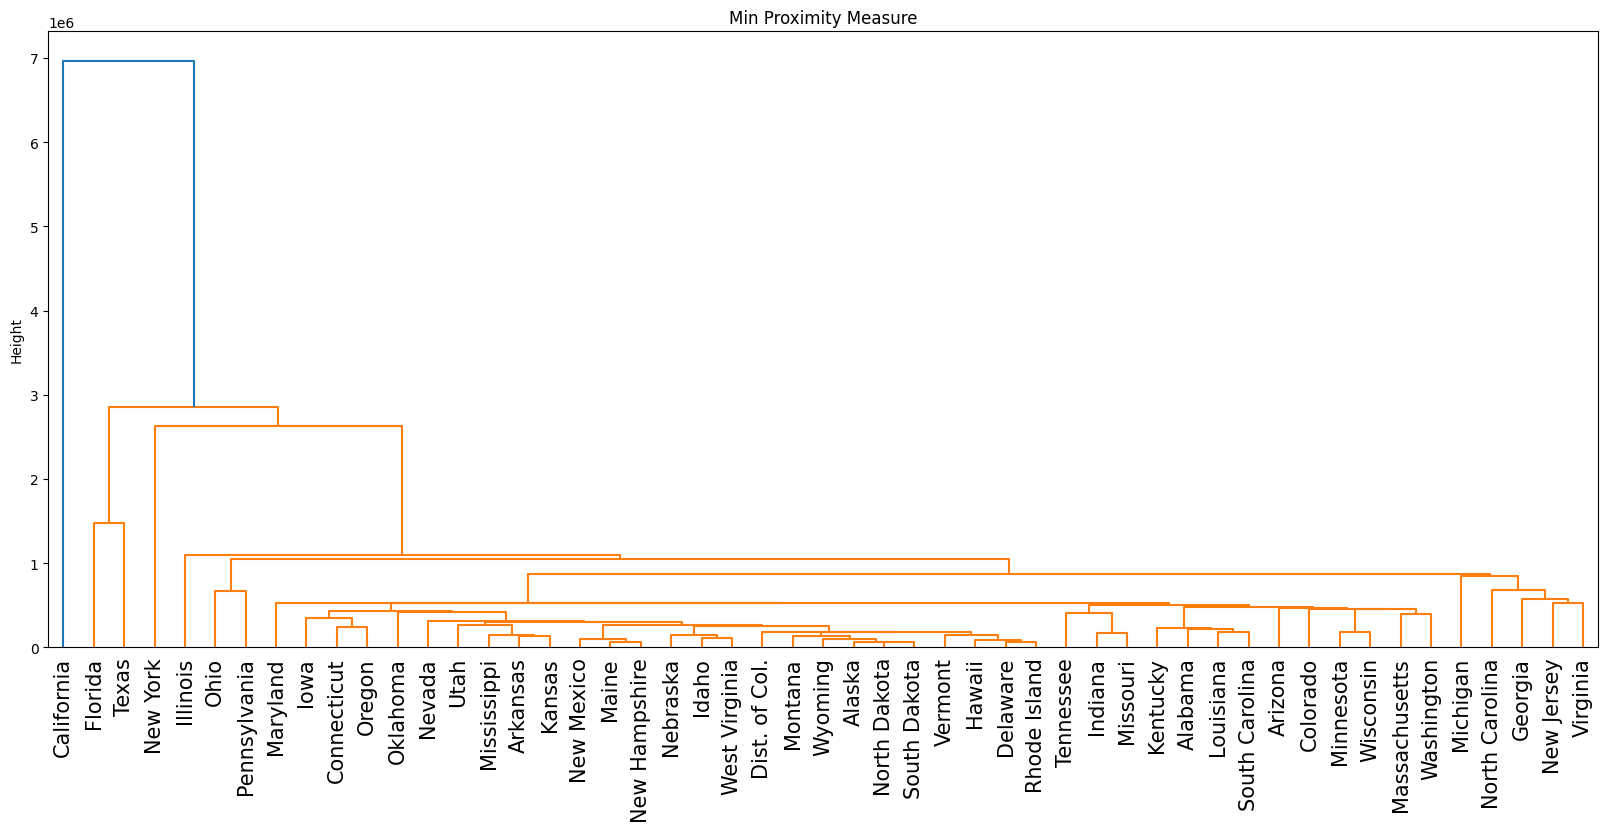

In [4]:
# Plot the dendrogram for the min proximity measure
distances = pdist(df_X)
Z = linkage(distances, method='single')
plt.figure(figsize=(20, 8))
dn = dendrogram(Z, labels = s_states.tolist(), leaf_font_size = 15)
plt.ylabel('Height')
plt.title('Min Proximity Measure');

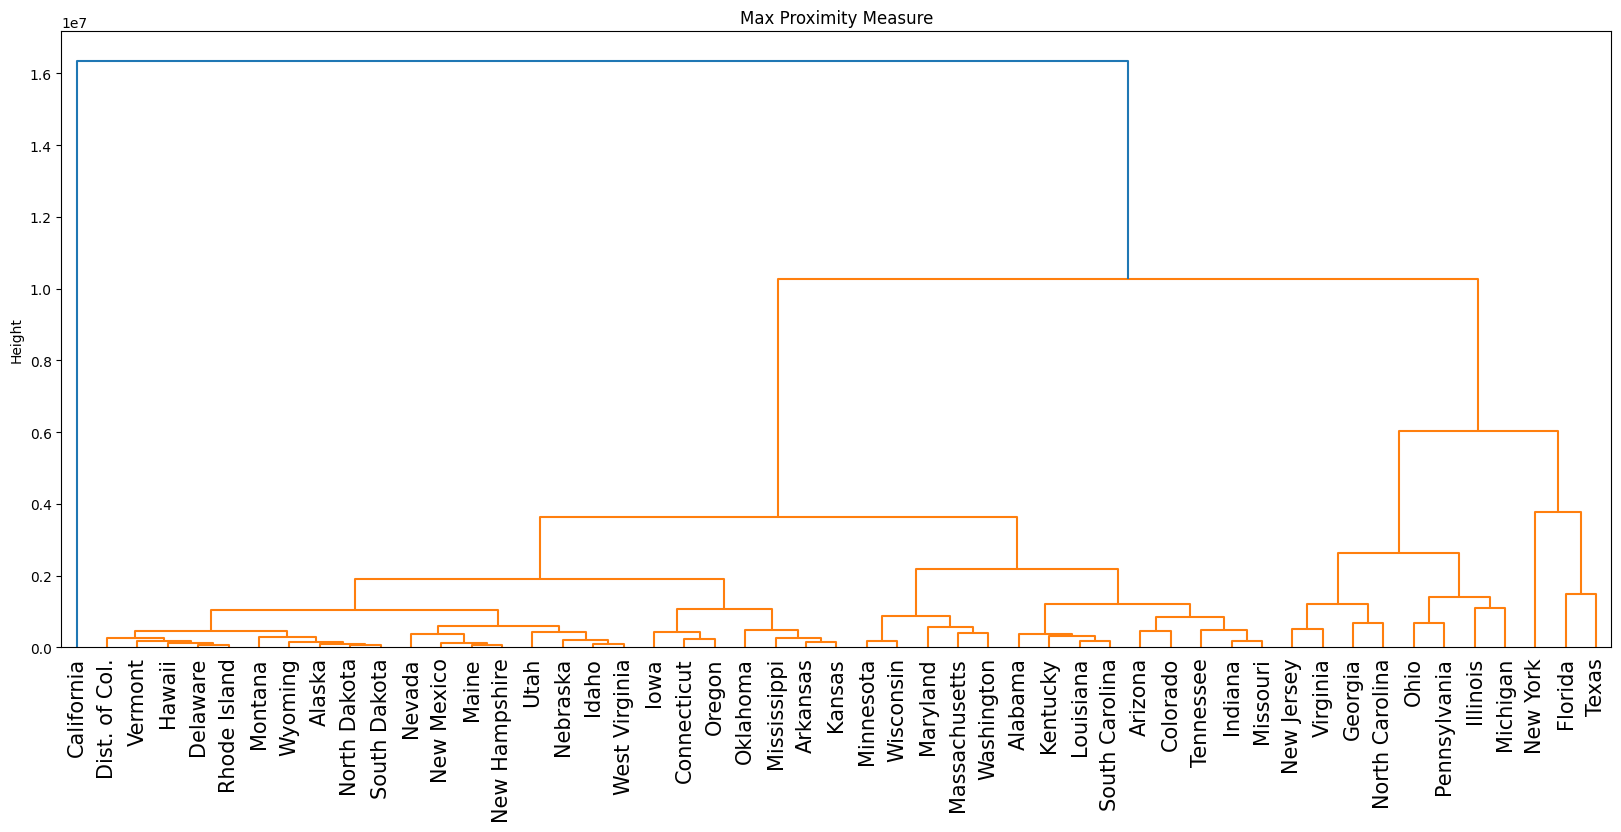

In [5]:
# Plot the dendrogram for the max proximity measure
distances = pdist(df_X)
Z = linkage(distances, method='complete')
plt.figure(figsize=(20, 8))
dn = dendrogram(Z, labels = s_states.tolist(), leaf_font_size = 15)
plt.ylabel('Height')
plt.title('Max Proximity Measure');

With each proximity measure, Montana, Wyoming, and Alaska all tend to cluster together. More suprisingly, New York is consistently clustered closer to Texas than it is to California. It seems that the population of each state is more important than which party actually won that state. With this in mind, it would be better to use percentages of votes. The second dataframe, republican_percentage_by_state.csv, was engineered from 7 attributes to 3 attributes where each column is the percentage of votes that were cast to the Republican candidate, and a 4th attribute indicating the range of percentages across the 3 elections.

## Re-test proximity measures on percentage data 

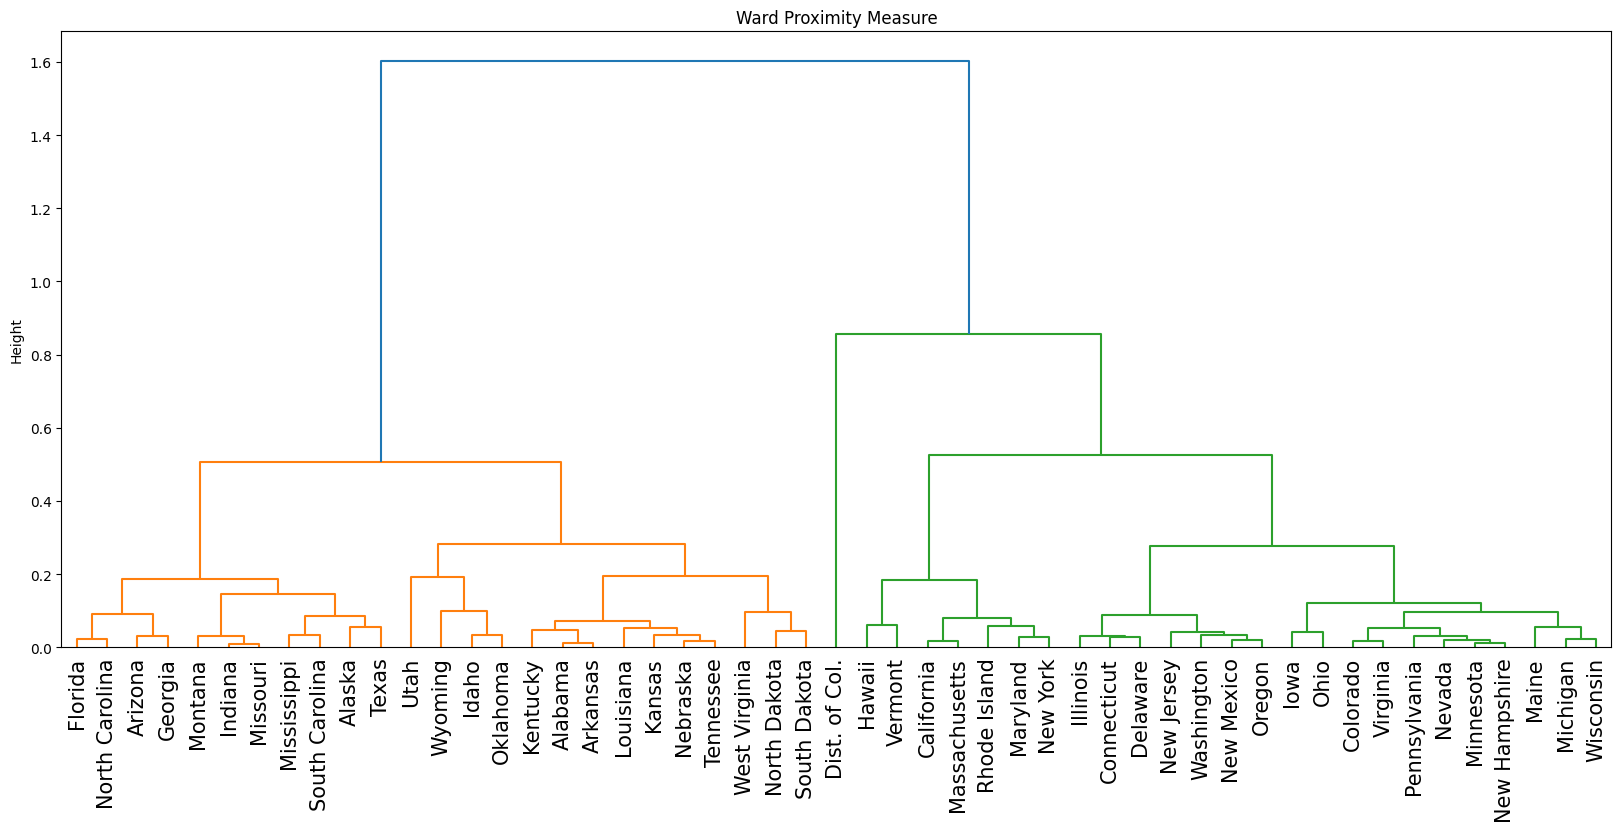

In [8]:
# Plot the dendrogram for the Ward proximity measure
distances = pdist(df_X)
Z_ward = linkage(distances, method='ward')
plt.figure(figsize=(20, 8))
dn = dendrogram(Z_ward, labels = s_states.tolist(), leaf_font_size = 15)
plt.ylabel('Height')
plt.title('Ward Proximity Measure');

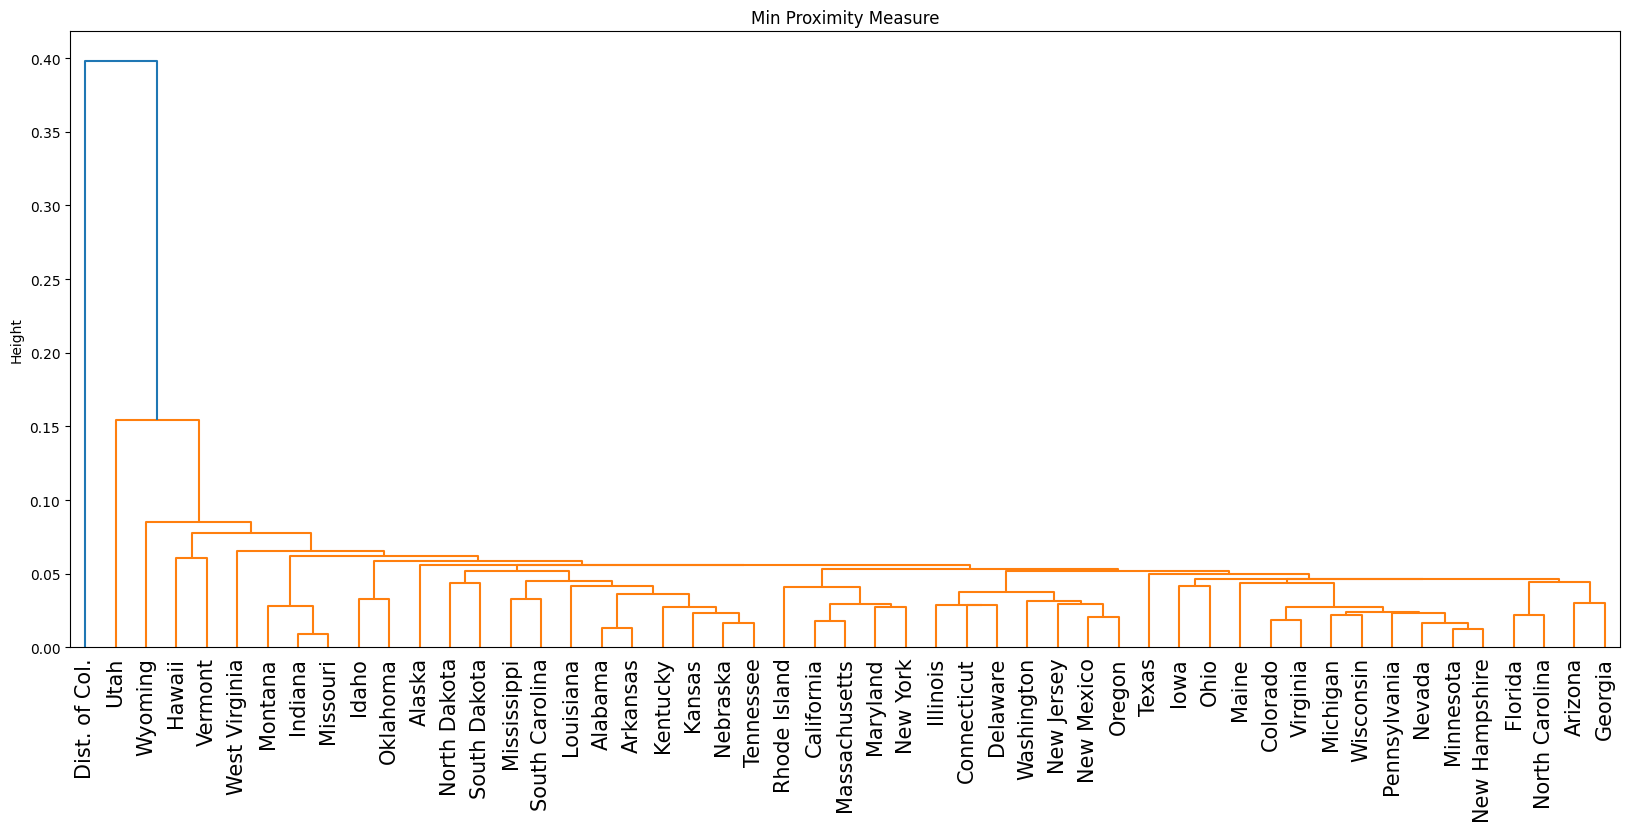

In [9]:
# Plot the dendrogram for the min proximity measure
distances = pdist(df_X)
Z_min = linkage(distances, method='single')
plt.figure(figsize=(20, 8))
dn = dendrogram(Z_min, labels = s_states.tolist(), leaf_font_size = 15)
plt.ylabel('Height')
plt.title('Min Proximity Measure');

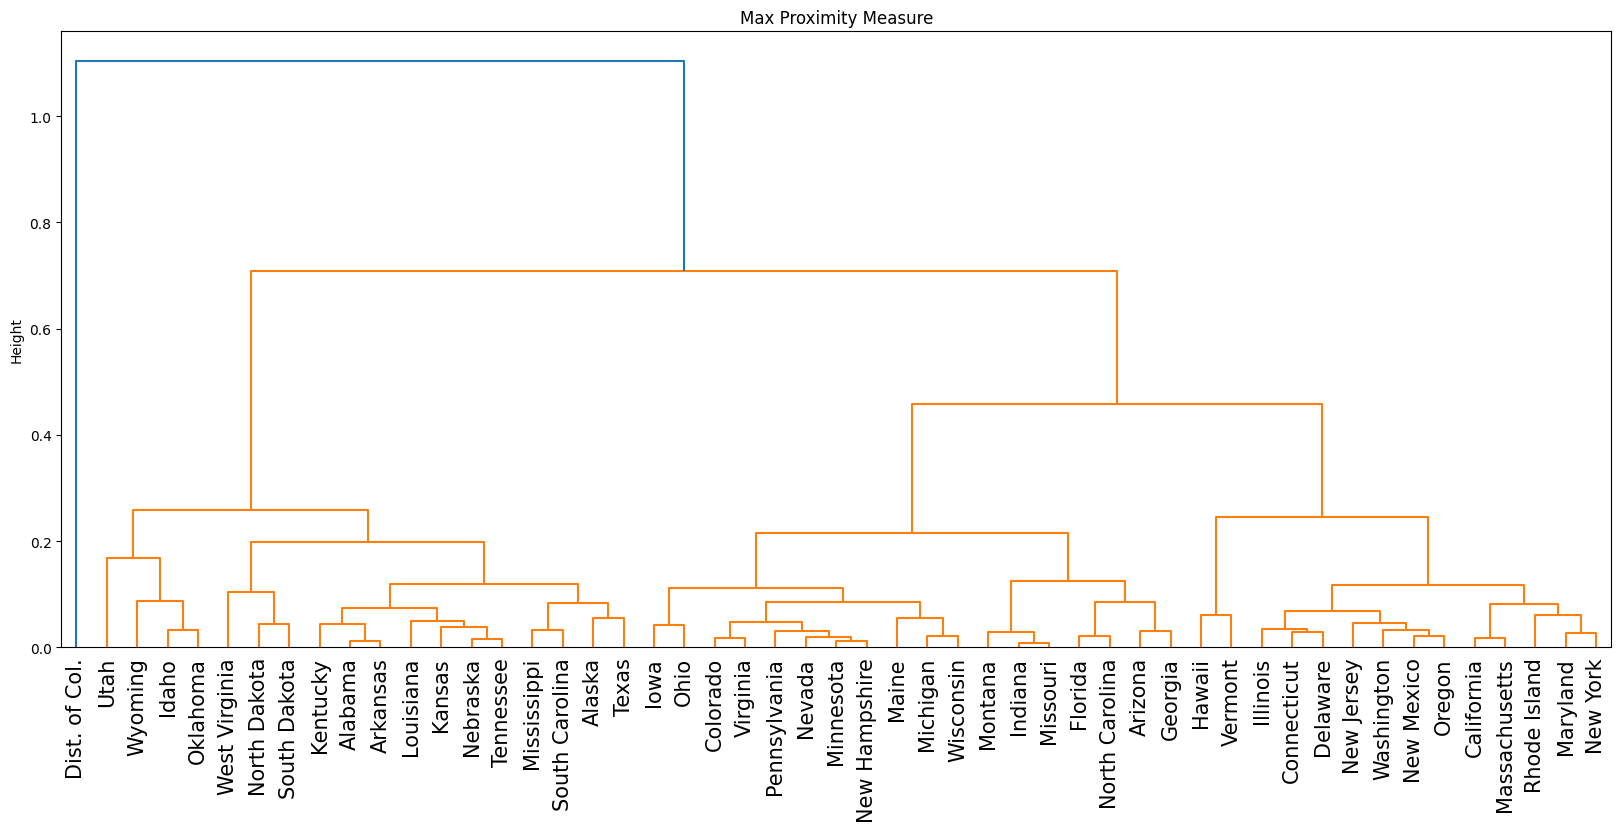

In [10]:
# Plot the dendrogram for the max proximity measure
distances = pdist(df_X)
Z_max = linkage(distances, method='complete')
plt.figure(figsize=(20, 8))
dn = dendrogram(Z_max, labels = s_states.tolist(), leaf_font_size = 15)
plt.ylabel('Height')
plt.title('Max Proximity Measure');

These hierarchies make more intuitive sense as New York and California are clustered closer than New York and Texas. 

## Calculate the Cophenetic Correlation Coefficient (CPCC)

Using the percentage data, calculate the CPCC for each of the three methods.

The CPCC evaluates the similarity between the pair-wise distance matrix of the original data and the clustering shown in the dendrogram. A high CPCC (close to 1) indicates that the dendogram well represents the original distances between points and therefore, that the clustering is accurate. 

In [12]:
cpcc_ward = cophenet(Z_ward, Y = pdist(df_X))[0]
cpcc_min = cophenet(Z_min, Y = pdist(df_X))[0]
cpcc_max = cophenet(Z_max, Y = pdist(df_X))[0]
(cpcc_ward,cpcc_min,cpcc_max)

(0.5883071696030502, 0.695463585768092, 0.7406937703705782)

Based on the CPCCs just calculated, it seems that the max proximity measure provides the most accurate clustering of the data. 

## Find new clusters with K-means

We now want to generate 4 clusters to inform 4 campaign strategies. Using the Ward proximity measure, implement the k-means algorithm using k=4 and the following initiation points: 
  - Montana
  - Arkansas
  - Massachusetts
  - Minnesota

Using random_state = 23. 

In [13]:
# Find the centroids
idxs = []
for i in range(len(s_states)):
    if s_states[i] in ['Montana', 'Arkansas', 'Massachusetts', 'Minnesota']:
        idxs.append(i)
centroids = []
for idx in idxs:
    row = df_X.iloc[idx].values.tolist()
    centroids.append(row)
centroids = np.array(centroids)

In [14]:
centroids 

array([[0.62534252, 0.62154405, 0.60171721, 0.02362531],
       [0.33835509, 0.38214319, 0.36802922, 0.04378811],
       [0.47186924, 0.46058773, 0.44770625, 0.02416299],
       [0.5757692 , 0.57034232, 0.51169403, 0.06407517]])

In [15]:
# Compute the k-means clusters and show the listing of the States in each cluster
kmeans = KMeans(n_clusters=4, random_state = 23, init = centroids, n_init = 1)
kmeans = kmeans.fit(df_X)
assignment = kmeans.labels_

for cluster in range(4):
    print('Cluster ' + str(cluster) + ':')
    for i in range(len(s_states)):
        if assignment[i] == cluster:
            print(s_states[i])
    print()

Cluster 0:
Alabama
Arkansas
Idaho
Kentucky
Nebraska
North Dakota
Oklahoma
Tennessee
Utah
West Virginia
Wyoming

Cluster 1:
California
Dist. of Col.
Hawaii
Maryland
Massachusetts
New York
Rhode Island
Vermont

Cluster 2:
Colorado
Connecticut
Delaware
Florida
Illinois
Iowa
Maine
Michigan
Minnesota
Nevada
New Hampshire
New Jersey
New Mexico
Ohio
Oregon
Pennsylvania
Virginia
Washington
Wisconsin

Cluster 3:
Alaska
Arizona
Georgia
Indiana
Kansas
Louisiana
Mississippi
Missouri
Montana
North Carolina
South Carolina
South Dakota
Texas



## Visualize the Silhouette Coefficients for each cluster 

Calculate the silhouette coefficient for each of the States in our data frame using the clustering from above.

States with Negative Silhouette Coefficients: Nebraska, Rhode Island


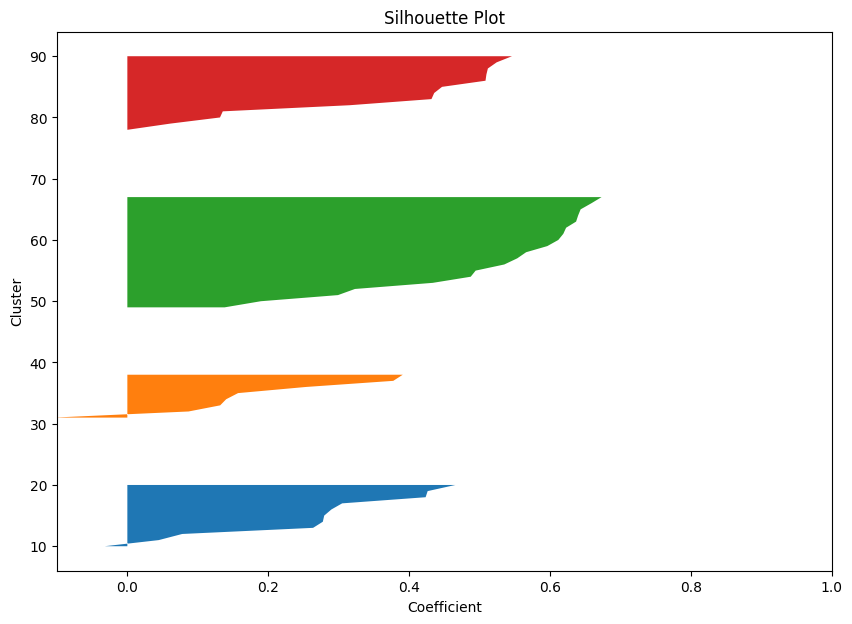

In [16]:
coeffs = silhouette_samples(df_X, assignment)
n_clusters = 4
fig, ax = plt.subplots(figsize=(10,7))

y_bottom = 10

for i in range(n_clusters):
    cluster = coeffs[assignment == i]
    cluster.sort()
    size = len(cluster)
    y_top = y_bottom + size
    ax.fill_betweenx(
        np.arange(y_bottom, y_top),
        0, 
        cluster)
    
    y_bottom = y_top + 10

ax.set_xlim([-0.1, 1])
ax.set_title("Silhouette Plot")
ax.set_xlabel("Coefficient")
ax.set_ylabel("Cluster")

outliers = []
for i in range(len(s_states)):
    if coeffs[i] < 0:
        outliers.append(s_states[i])
print('States with Negative Silhouette Coefficients:', outliers[0] + ',', outliers[1])

- This plot shows us how well the clustering algorithm performed on this dataset. A high coefficient value (close to 1) indicates that the point fits well into its cluster, while a low coefficient indicates that that instance does not fit well into its cluster. 
- Based on just the shape/length of the bars, I would assume that the orange and blue clusters are less similar than the green and red clusters. This is because they are a lot less long and wide, meaning there are less points in these clusters and their silhouette coefficients are smaller. 
- Both the orange and blue clusters have points with negative coefficients, indicating that they are not very similar to other points in their cluster. The two points with negative coefficients are the states Nebraska and Rhode Island.